In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import mysql.connector as sql

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
def mse(x, y):
    summation = 0
    n = len(y)
    for i in range(0, n):
        difference = y[i] - x[i]
        squared_difference = difference ** 2
        summation = summation + squared_difference
    return summation / n


def correlation(x, y):
    mean_x = sum(x) / float(len(x))
    mean_y = sum(y) / float(len(y))

    sub_x = [i - mean_x for i in x]

    sub_y = [i - mean_y for i in y]
    numerator = sum([sub_x[i] * sub_y[i] for i in range(len(sub_x))])

    std_deviation_x = sum([sub_x[i] ** 2.0 for i in range(len(sub_x))])
    std_deviation_y = sum([sub_y[i] ** 2.0 for i in range(len(sub_y))])

    denominator = (std_deviation_x * std_deviation_y) ** 0.5
    cor = numerator / denominator
    return cor

def train_test_split(data):
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size:]
    test_data = data[train_size:]
    return train_data, test_data, data.keys()

def calcDistancs(pointA, pointB, numOfFeature):
    tmp = 0
    for i in range(numOfFeature):
        tmp += (float(pointA[i]) - float(pointB[i])) ** 2
    return math.sqrt(tmp)


def kNearestNeighbor(train_data, point, k):
    distances = []
    for row in train_data.values:
        distances.append({"label": row[-1], "value": calcDistancs(row, point, len(train_data.columns))})
    distances.sort(key=lambda x: x["value"])
    labels = [value["label"] for value in distances]
    return labels[:k]


def findMostOccur(arr):
    labels = set(arr)
    ans = ""
    maxOccur = 0
    for label in labels:
        num = arr.count(label)
        if num > maxOccur:
            maxOccur = num
            ans = label
    return ans

In [11]:
my_conn = sql.connect(host="sq16.freesqldatabase.com", database="sq16585183", user="sq16585183", password="KXRjzwwCfW")
data = pd.read_sql("SELECT * FROM dataset ", my_conn)
# data = pd.read_csv('dataset.csv')

data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,44,1,4,111,170,0,2,150,0,0.3,1,0,3,0
1,48,0,3,118,285,0,0,145,0,0.3,2,1,3,1
2,47,1,4,115,312,0,0,187,0,1.3,2,0,3,1
3,51,1,3,96,237,0,0,156,1,0.5,1,1,3,1
4,51,1,3,99,227,0,0,155,1,0.2,1,1,3,1


In [12]:
data.shape

(21060, 14)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21060 entries, 0 to 21059
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       21060 non-null  int64  
 1   sex       21060 non-null  int64  
 2   cp        21060 non-null  int64  
 3   trestbps  21060 non-null  int64  
 4   chol      21060 non-null  int64  
 5   fbs       21060 non-null  int64  
 6   restecg   21060 non-null  int64  
 7   thalach   21060 non-null  int64  
 8   exang     21060 non-null  int64  
 9   oldpeak   21060 non-null  float64
 10  slope     21060 non-null  int64  
 11  ca        21060 non-null  int64  
 12  thal      21060 non-null  int64  
 13  target    21060 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 2.2 MB


In [15]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000,21060.00000,21060.000000,21060.000000,21060.000000,21060.000000,21060.000000
mean,53.037654,0.677778,3.174074,131.139601,244.280342,0.148148,1.022222,149.446011,0.32963,1.171619,1.585185,0.670370,3.464245,0.547863
std,9.745630,0.467339,0.948351,19.007377,42.833553,0.355255,0.996065,23.990766,0.47009,1.112976,0.613266,0.942169,1.228840,0.497716
min,28.000000,0.000000,1.000000,94.000000,125.000000,0.000000,0.000000,70.000000,0.00000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,0.000000,3.000000,116.000000,213.000000,0.000000,0.000000,135.000000,0.00000,0.300000,1.000000,0.000000,3.000000,0.000000
50%,53.000000,1.000000,3.000000,129.000000,240.000000,0.000000,2.000000,153.000000,0.00000,0.800000,2.000000,0.000000,3.000000,1.000000
75%,60.000000,1.000000,4.000000,145.000000,283.000000,0.000000,2.000000,167.000000,1.00000,1.700000,2.000000,1.000000,3.000000,1.000000
max,78.000000,1.000000,4.000000,179.000000,319.000000,1.000000,2.000000,203.000000,1.00000,6.200000,3.000000,3.000000,7.000000,1.000000


In [16]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [17]:
data['target'].value_counts()

1    11538
0     9522
Name: target, dtype: int64

In [18]:
data['target'].value_counts()/data.shape[0]*100

1    54.786325
0    45.213675
Name: target, dtype: float64

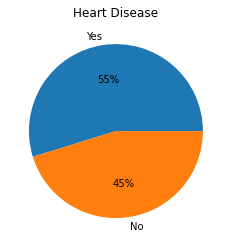

In [19]:
labels = ['Yes', 'No']
values = data['target'].value_counts().values

plt.pie(values, labels=labels, autopct='%1.0f%%')
plt.title('Heart Disease')
plt.show()


In [23]:
trainSet, testSet, header = train_test_split(data)
x_train = trainSet.drop(labels='target', axis=1)
y_train = trainSet['target']
x_test = testSet.drop(labels='target', axis=1)
y_test = testSet['target']

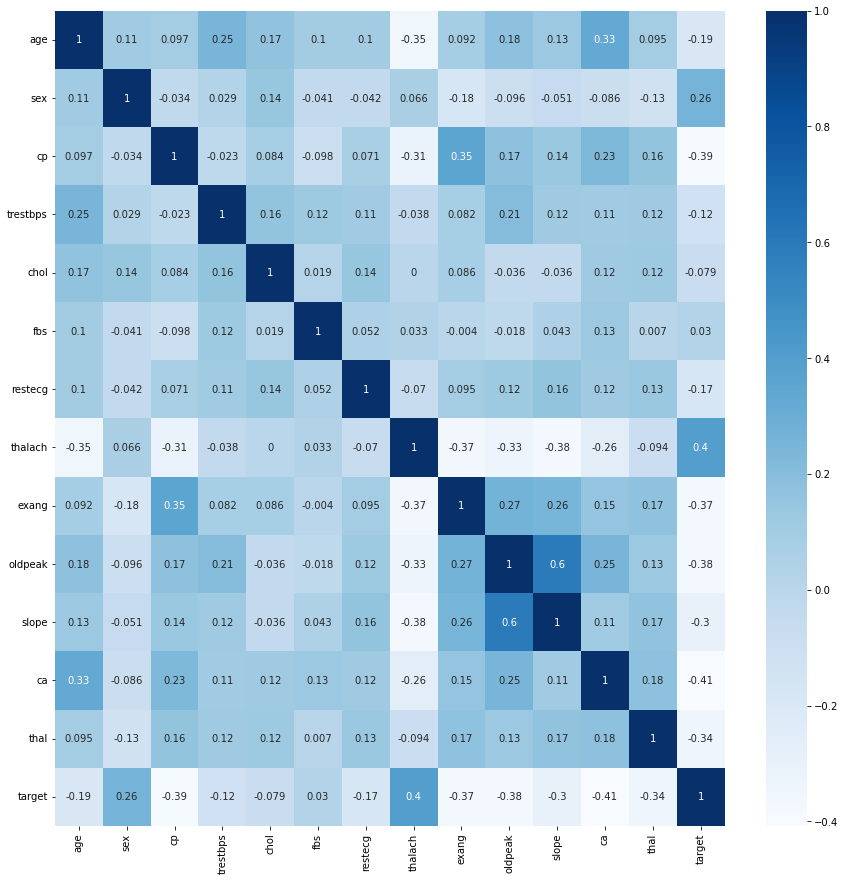

In [25]:
corr = []
corr_matrix = []

for i in header:
    tmp = []
    for j in header:
        tmp.append(round(correlation(trainSet[i], trainSet[j]), 3))
    corr.append(tmp)

corr = pd.DataFrame(data=corr, index=header, columns=header)

sns.heatmap(corr, annot=True, cmap="Blues")
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()

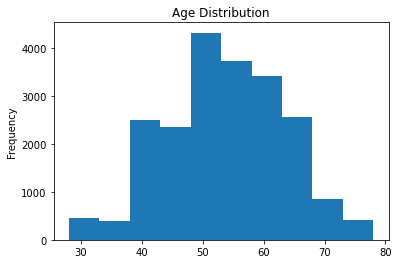

In [26]:
data['age'].plot(kind='hist', title='Age Distribution')
plt.show()

In [27]:
print('Min age: ', min(data['age']))
print('Max age: ', max(data['age']))
print('Average age: ', data['age'].mean())

Min age:  28
Max age:  78
Average age:  53.037654320987656


c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\Users\FPT Shop\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret

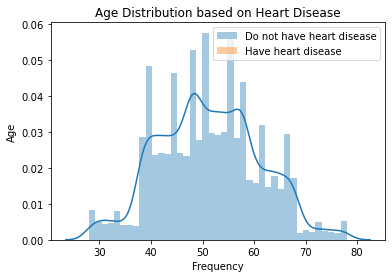

In [28]:
sns.distplot(data[data['target'] == 1]['age'], label='Do not have heart disease')
sns.distplot(data[data['target'] == 2]['age'], label='Have heart disease')
plt.xlabel('Frequency')
plt.ylabel('Age')
plt.title('Age Distribution based on Heart Disease')
plt.legend()
plt.show()


In [29]:
print('Min age of people who do not have heart disease: ',
      min(data[data['target'] == 0]['age']))
print('Max age of people who do not have heart disease: ',
      max(data[data['target'] == 0]['age']))
print('Average age of people who do not have heart disease: ',
      data[data['target'] == 0]['age'].mean())


Min age of people who do not have heart disease:  28
Max age of people who do not have heart disease:  78
Average age of people who do not have heart disease:  55.10270951480781


In [30]:
print('Min age of people who have heart disease: ',
      min(data[data['target'] == 1]['age']))
print('Max age of people who have heart disease: ',
      max(data[data['target'] == 1]['age']))
print('Average age of people who have heart disease: ',
      data[data['target'] == 1]['age'].mean())


Min age of people who have heart disease:  28
Max age of people who have heart disease:  78
Average age of people who have heart disease:  51.333420003466806


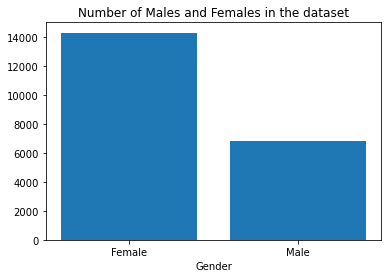

In [31]:
F = data[data['sex'] == 0].count()['target']
M = data[data['sex'] == 1].count()['target']

# Create a plot
figure, ax = plt.subplots(figsize=(6, 4))
ax.bar(x=['Female', 'Male'], height=[F, M])
plt.xlabel('Gender')
plt.title('Number of Males and Females in the dataset')
plt.show()


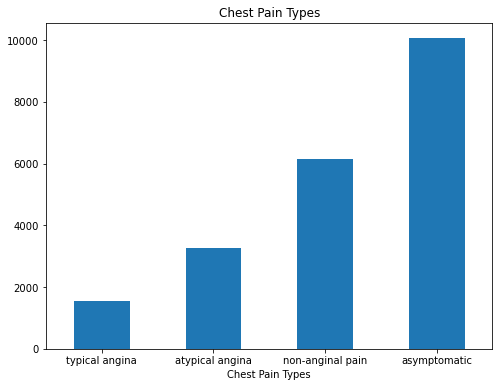

In [32]:
data.groupby(data['cp']).count()['target'].plot(
    kind='bar', title='Chest Pain Types', figsize=(8, 6))
plt.xlabel('Chest Pain Types')
plt.xticks(np.arange(4), ('typical angina', 'atypical angina',
           'non-anginal pain', 'asymptomatic'), rotation=0)
plt.show()


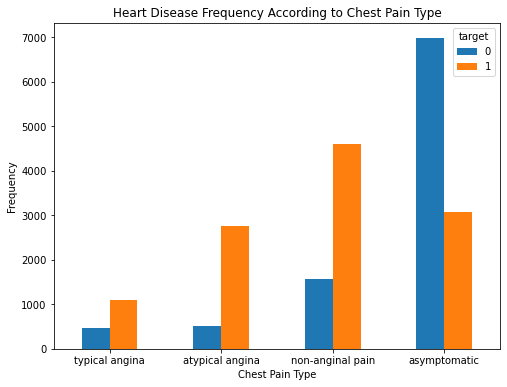

In [33]:
pd.crosstab(data.cp, data.target).plot(kind="bar", figsize=(8, 6))
plt.title('Heart Disease Frequency According to Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(np.arange(4), ('typical angina', 'atypical angina',
           'non-anginal pain', 'asymptomatic'), rotation=0)
plt.ylabel('Frequency')
plt.show()


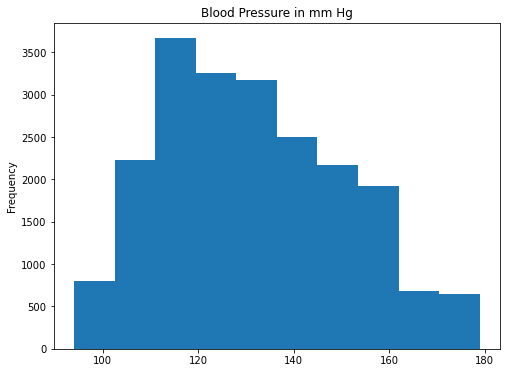

In [34]:
data['trestbps'].plot(
    kind='hist', title='Blood Pressure in mm Hg', figsize=(8, 6))
plt.show()


c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\Users\FPT Shop\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret

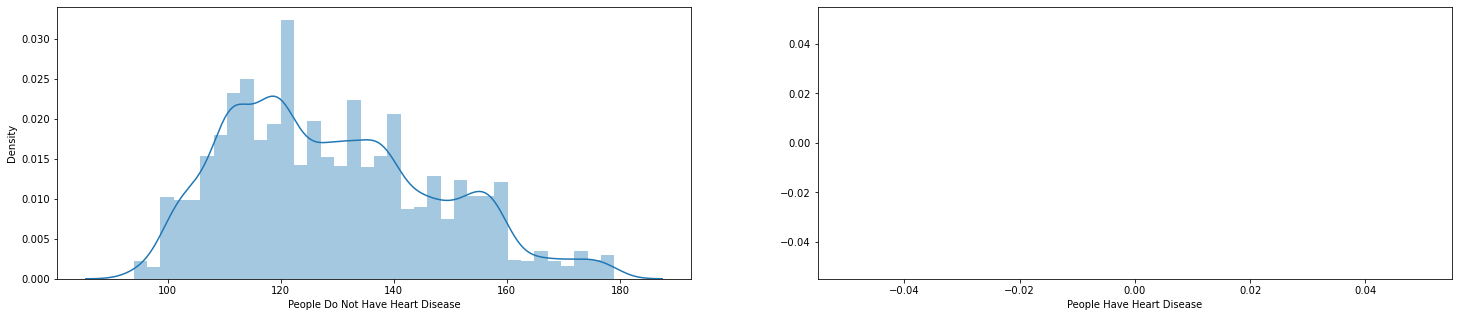

In [35]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(25, 5))
ax = sns.distplot(data[data['target'] == 1]['trestbps'],
                  label='Do not have heart disease', ax=axis1)
ax.set(xlabel='People Do Not Have Heart Disease')
ax = sns.distplot(data[data['target'] == 2]['trestbps'],
                  label='Have heart disease', ax=axis2)
ax.set(xlabel='People Have Heart Disease')
plt.show()


In [36]:
print('Min blood pressure of people who do not have heart disease: ',
      min(data[data['target'] == 0]['trestbps']))
print('Max blood pressure of people who do not have heart disease: ',
      max(data[data['target'] == 0]['trestbps']))
print('Average blood pressure of people who do not have heart disease: ',
      data[data['target'] == 0]['trestbps'].mean())


Min blood pressure of people who do not have heart disease:  94
Max blood pressure of people who do not have heart disease:  179
Average blood pressure of people who do not have heart disease:  133.72064692291536


In [37]:
print('Min blood pressure of people who have heart disease: ',
      min(data[data['target'] == 1]['trestbps']))
print('Max blood pressure of people who have heart disease: ',
      max(data[data['target'] == 1]['trestbps']))
print('Average blood pressure of people who have heart disease: ',
      data[data['target'] == 1]['trestbps'].mean())


Min blood pressure of people who have heart disease:  94
Max blood pressure of people who have heart disease:  179
Average blood pressure of people who have heart disease:  129.0095337146819


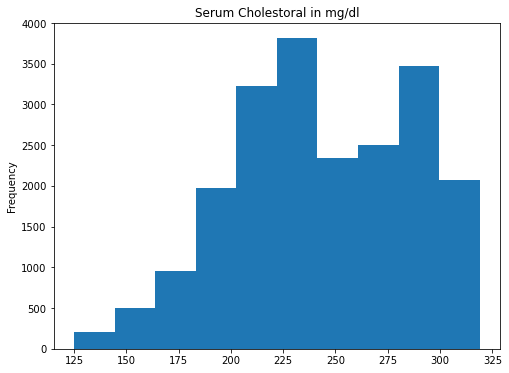

In [38]:
data['chol'].plot(
    kind='hist', title='Serum Cholestoral in mg/dl', figsize=(8, 6))
plt.show()


c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\Users\FPT Shop\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret

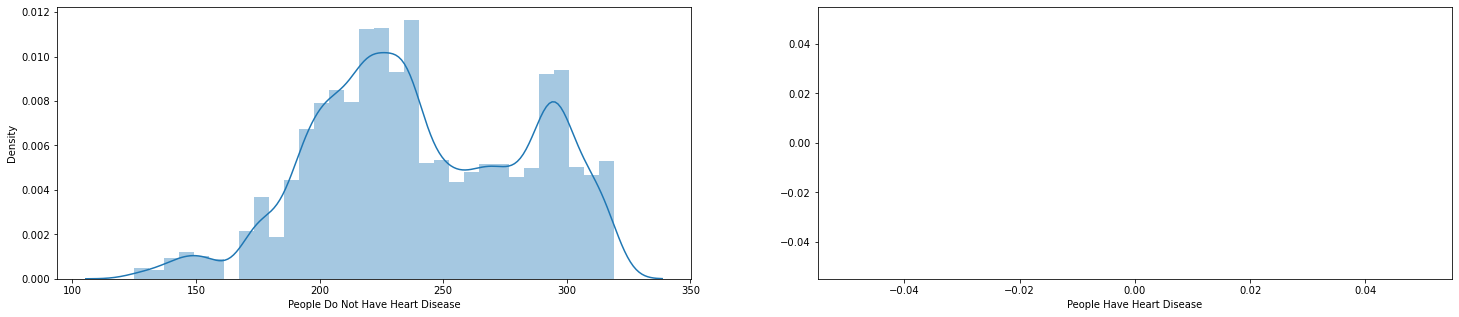

In [39]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(25, 5))
ax = sns.distplot(data[data['target'] == 1]['chol'],
                  label='Do not have heart disease', ax=axis1)
ax.set(xlabel='People Do Not Have Heart Disease')
ax = sns.distplot(data[data['target'] == 2]['chol'],
                  label='Have heart disease', ax=axis2)
ax.set(xlabel='People Have Heart Disease')
plt.show()


In [40]:
print('Min cholestoral of people who do not have heart disease: ',
      min(data[data['target'] == 0]['chol']))
print('Max cholestoral of people who do not have heart disease: ',
      max(data[data['target'] == 0]['chol']))
print('Average cholestoral of people who do not have heart disease: ',
      data[data['target'] == 0]['chol'].mean())


Min cholestoral of people who do not have heart disease:  140
Max cholestoral of people who do not have heart disease:  319
Average cholestoral of people who do not have heart disease:  247.99422390254148


In [41]:
print('Min cholestoral of people who have heart disease: ',
      min(data[data['target'] == 1]['chol']))
print('Max cholestoral of people who have heart disease: ',
      max(data[data['target'] == 1]['chol']))
print('Average cholestorale of people who have heart disease: ',
      data[data['target'] == 1]['chol'].mean())


Min cholestoral of people who have heart disease:  125
Max cholestoral of people who have heart disease:  319
Average cholestorale of people who have heart disease:  241.21537528167792


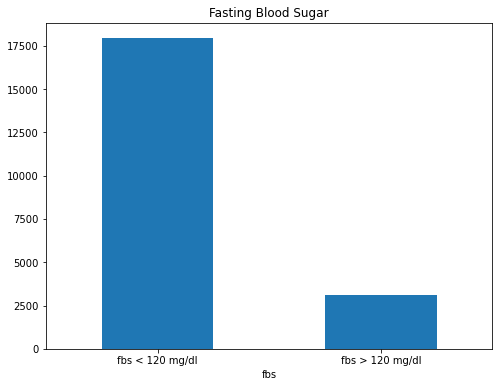

In [42]:
data.groupby(data['fbs']).count()['target'].plot(
    kind='bar', title='Fasting Blood Sugar', figsize=(8, 6))
plt.xticks(np.arange(2), ('fbs < 120 mg/dl', 'fbs > 120 mg/dl'), rotation=0)
plt.show()

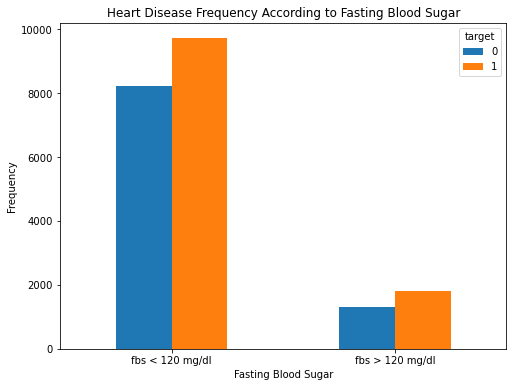

In [43]:
pd.crosstab(data.fbs, data.target).plot(kind="bar", figsize=(8, 6))
plt.title('Heart Disease Frequency According to Fasting Blood Sugar')
plt.xlabel('Fasting Blood Sugar')
plt.xticks(np.arange(2), ('fbs < 120 mg/dl', 'fbs > 120 mg/dl'), rotation=0)
plt.ylabel('Frequency')
plt.show()

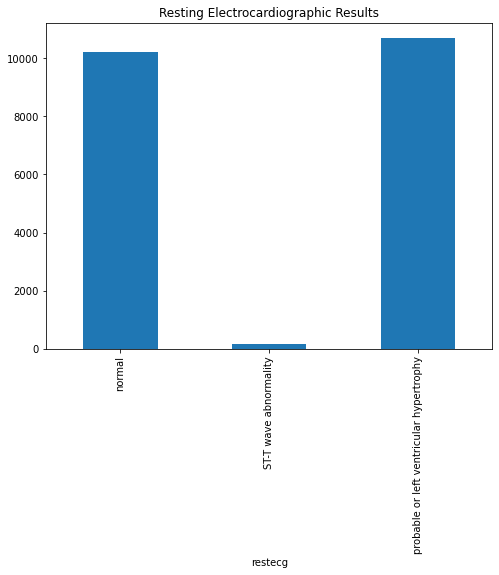

In [44]:
data.groupby(data['restecg']).count()['target'].plot(
    kind='bar', title='Resting Electrocardiographic Results', figsize=(8, 6))
plt.xticks(np.arange(3), ('normal', 'ST-T wave abnormality',
           'probable or left ventricular hypertrophy'))
plt.show()


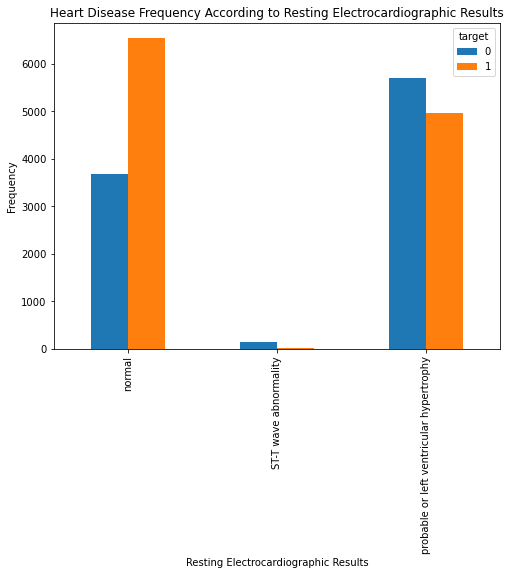

In [45]:
pd.crosstab(data.restecg, data.target).plot(kind="bar", figsize=(8, 6))
plt.title('Heart Disease Frequency According to Resting Electrocardiographic Results')
plt.xticks(np.arange(3), ('normal', 'ST-T wave abnormality',
           'probable or left ventricular hypertrophy'))
plt.xlabel('Resting Electrocardiographic Results')
plt.ylabel('Frequency')
plt.show()


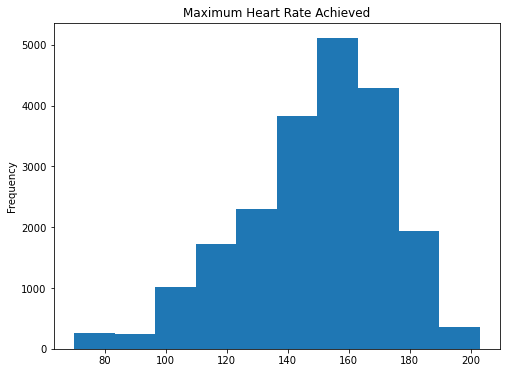

In [46]:
data['thalach'].plot(
    kind='hist', title='Maximum Heart Rate Achieved', figsize=(8, 6))
plt.show()


c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\Users\FPT Shop\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret

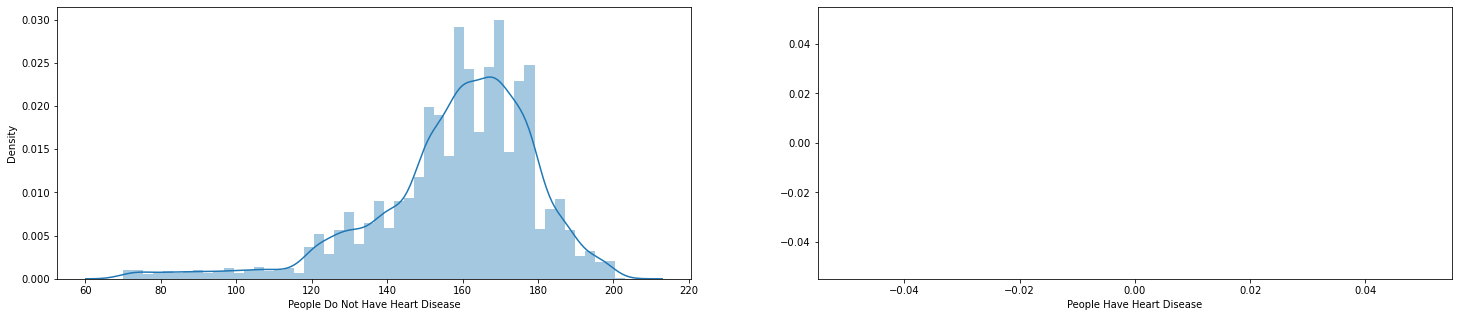

In [47]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(25, 5))
ax = sns.distplot(data[data['target'] == 1]['thalach'],
                  label='Do not have heart disease', ax=axis1)
ax.set(xlabel='People Do Not Have Heart Disease')
ax = sns.distplot(data[data['target'] == 2]['thalach'],
                  label='Have heart disease', ax=axis2)
ax.set(xlabel='People Have Heart Disease')
plt.show()


In [48]:
print('Min resting blood pressure of people who do not have heart disease: ',
      min(data[data['target'] == 0]['thalach']))
print('Max resting blood pressure of people who do not have heart disease: ',
      max(data[data['target'] == 0]['thalach']))
print('Average resting blood pressure of people who do not have heart disease: ',
      data[data['target'] == 0]['thalach'].mean())


Min resting blood pressure of people who do not have heart disease:  70
Max resting blood pressure of people who do not have heart disease:  199
Average resting blood pressure of people who do not have heart disease:  138.8731358958202


In [49]:
print('Min maximum heart rate  of people who have heart disease: ',
      min(data[data['target'] == 1]['thalach']))
print('Max maximum heart rate people who have heart disease: ',
      max(data[data['target'] == 1]['thalach']))
print('Average maximum heart rate of people who have heart disease: ',
      data[data['target'] == 1]['thalach'].mean())


Min maximum heart rate  of people who have heart disease:  70
Max maximum heart rate people who have heart disease:  203
Average maximum heart rate of people who have heart disease:  158.1715201941411


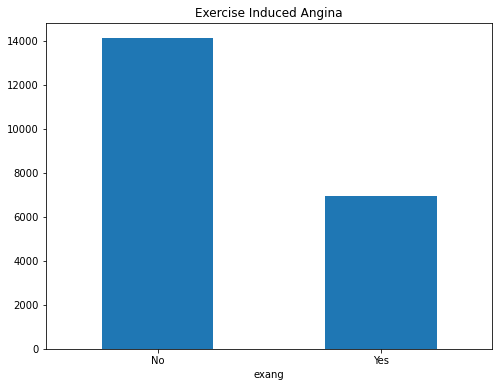

In [51]:
data.groupby(data['exang']).count()['target'].plot(
    kind='bar', title='Exercise Induced Angina',  figsize=(8, 6))
plt.xticks(np.arange(2), ('No', 'Yes'), rotation=0)
plt.show()


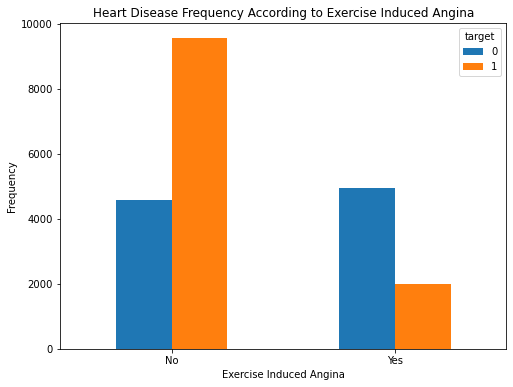

In [52]:
pd.crosstab(data.exang, data.target).plot(kind="bar", figsize=(8, 6))
plt.title('Heart Disease Frequency According to Exercise Induced Angina')
plt.xlabel('Exercise Induced Angina')
plt.xticks(np.arange(2), ('No', 'Yes'), rotation=0)
plt.ylabel('Frequency')
plt.show()


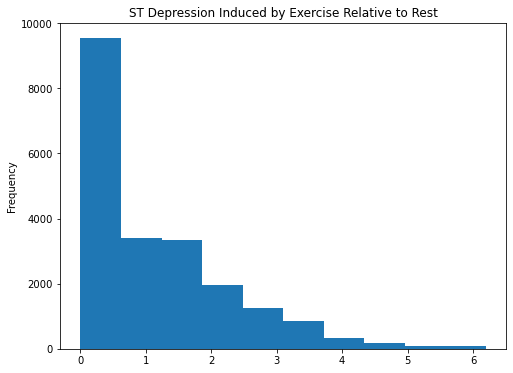

In [53]:
data['oldpeak'].plot(
    kind='hist', title='ST Depression Induced by Exercise Relative to Rest', figsize=(8, 6))
plt.show()


c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\Users\FPT Shop\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret

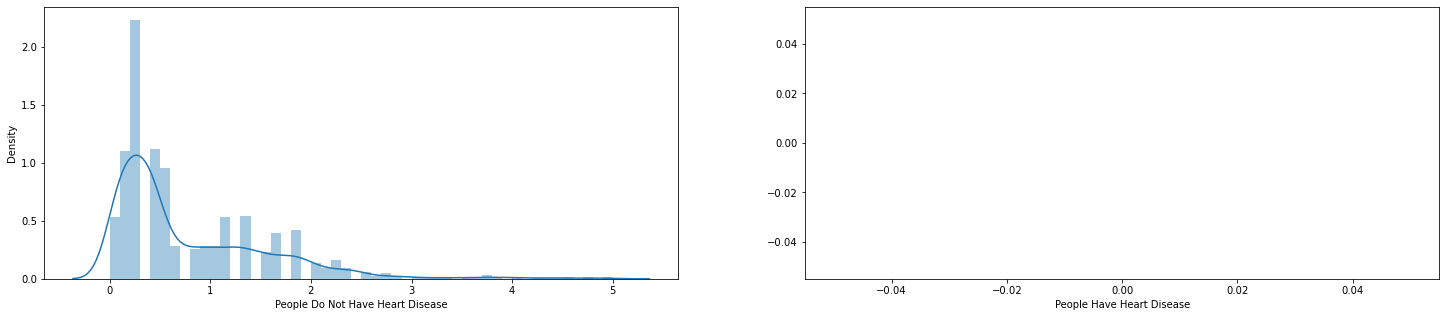

In [54]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(25, 5))
ax = sns.distplot(data[data['target'] == 1]['oldpeak'],
                  label='Do not have heart disease', ax=axis1)
ax.set(xlabel='People Do Not Have Heart Disease')
ax = sns.distplot(data[data['target'] == 2]['oldpeak'],
                  label='Have heart disease', ax=axis2)
ax.set(xlabel='People Have Heart Disease')
plt.show()


In [55]:
print('Min ST depression of people who do not have heart disease: ',
      min(data[data['target'] == 0]['oldpeak']))
print('Max ST depression of people who do not have heart disease: ',
      max(data[data['target'] == 0]['oldpeak']))
print('Average ST depression of people who do not have heart disease: ',
      data[data['target'] == 0]['oldpeak'].mean())


Min ST depression of people who do not have heart disease:  0.0
Max ST depression of people who do not have heart disease:  6.2
Average ST depression of people who do not have heart disease:  1.6367569838269247


In [56]:
print('Min ST depression of people who have heart disease: ',
      min(data[data['target'] == 1]['oldpeak']))
print('Max ST depression of people who have heart disease: ',
      max(data[data['target'] == 1]['oldpeak']))
print('Average ST depression of people not have heart disease: ',
      data[data['target'] == 1]['oldpeak'].mean())


Min ST depression of people who have heart disease:  0.0
Max ST depression of people who have heart disease:  5.0
Average ST depression of people not have heart disease:  0.7877535101404055


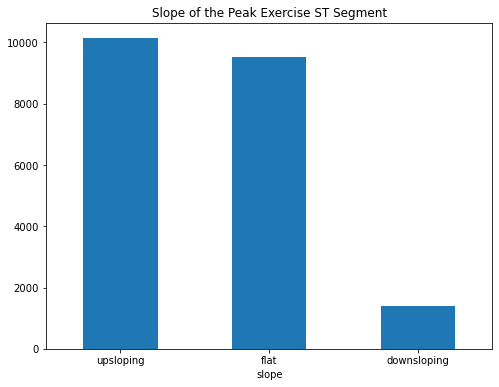

In [57]:
data.groupby(data['slope']).count()['target'].plot(
    kind='bar', title='Slope of the Peak Exercise ST Segment', figsize=(8, 6))
plt.xticks(np.arange(3), ('upsloping', 'flat', 'downsloping'), rotation=0)
plt.show()


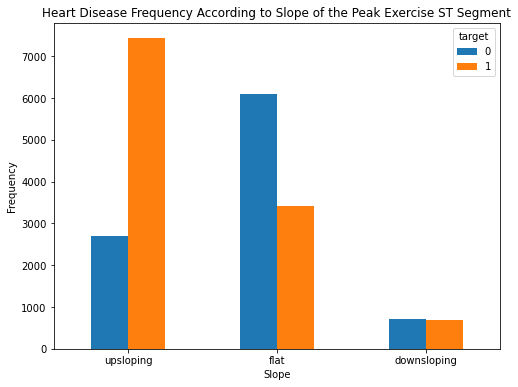

In [58]:
pd.crosstab(data.slope, data.target).plot(kind="bar", figsize=(8, 6))
plt.title(
    'Heart Disease Frequency According to Slope of the Peak Exercise ST Segment')
plt.xlabel('Slope')
plt.xticks(np.arange(3), ('upsloping', 'flat', 'downsloping'), rotation=0)
plt.ylabel('Frequency')
plt.show()


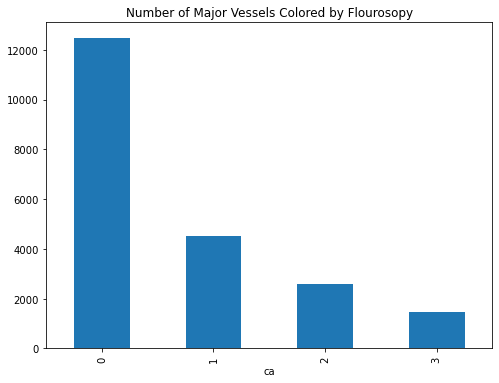

In [59]:
data.groupby(data['ca']).count()['target'].plot(kind='bar', title='Number of Major Vessels Colored by Flourosopy',
                                            figsize=(8, 6))
plt.show()


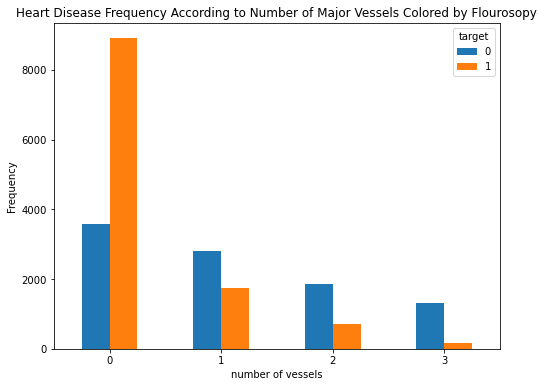

In [60]:
pd.crosstab(data.ca, data.target).plot(kind="bar", figsize=(8, 6))
plt.title(
    'Heart Disease Frequency According to Number of Major Vessels Colored by Flourosopy')
plt.xlabel('number of vessels')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()


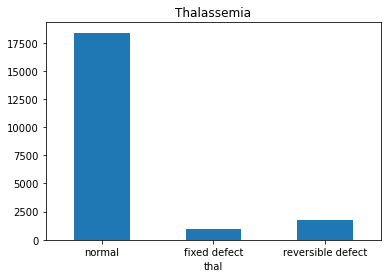

In [61]:
data.groupby(data['thal']).count()['target'].plot(kind='bar', title='Thalassemia')
plt.xticks(np.arange(3), ('normal', 'fixed defect',
           'reversible defect'), rotation=0)
plt.show()


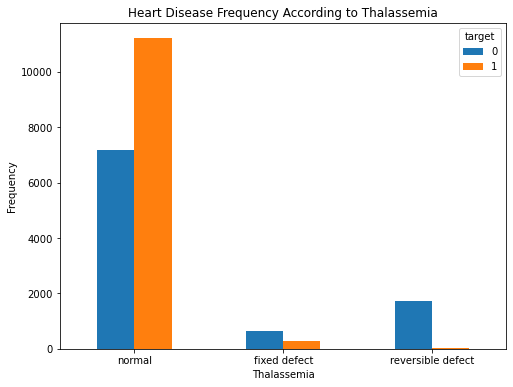

In [62]:
pd.crosstab(data.thal, data.target).plot(kind="bar", figsize=(8, 6))
plt.title('Heart Disease Frequency According to Thalassemia')
plt.xlabel('Thalassemia')
plt.xticks(np.arange(3), ('normal', 'fixed defect',
           'reversible defect'), rotation=0)
plt.ylabel('Frequency')
plt.show()


c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


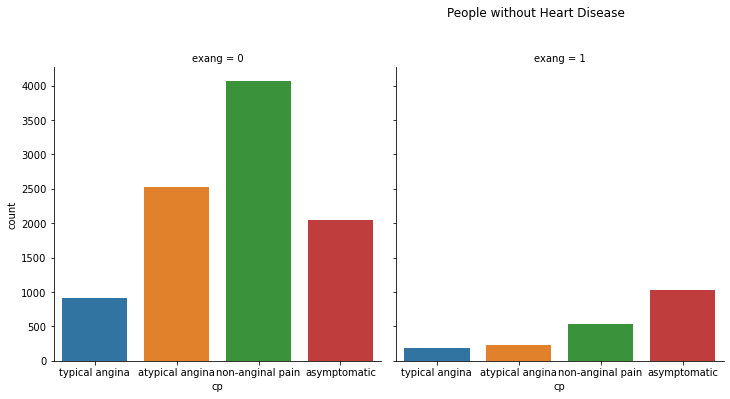

In [63]:
g = sns.factorplot("cp", col="exang", col_wrap=3,
                   data=data[data['target'] == 1], kind="count")
plt.xticks(np.arange(4), ('typical angina', 'atypical angina',
           'non-anginal pain', 'asymptomatic'), rotation=0)
g.fig.suptitle('People without Heart Disease', y=1.1)
plt.show()


c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


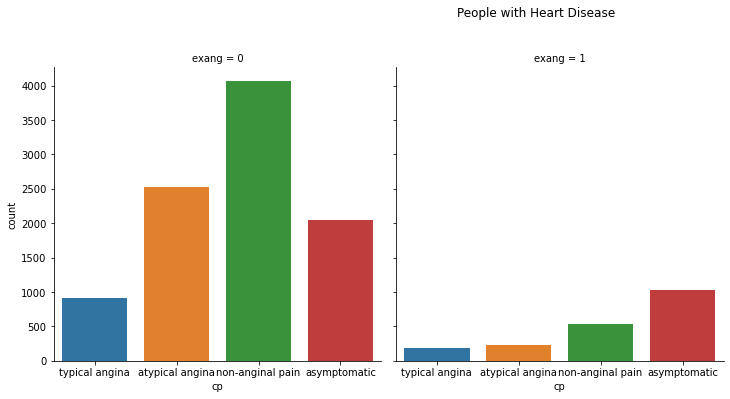

In [65]:
g = sns.factorplot("cp", col="exang", col_wrap=3,
                   data=data[data['target'] == 1], kind="count")
plt.xticks(np.arange(4), ('typical angina', 'atypical angina',
           'non-anginal pain', 'asymptomatic'), rotation=0)
g.fig.suptitle('People with Heart Disease', y=1.1)
plt.show()


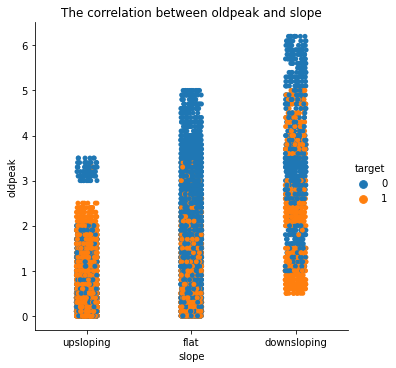

In [66]:
sns.catplot(x="slope", y="oldpeak", hue="target", data=data)
plt.title('The correlation between oldpeak and slope')
plt.xticks(np.arange(3), ('upsloping', 'flat', 'downsloping'), rotation=0)
plt.show()


c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 95.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 90.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 83.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\FPT Shop\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 69.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


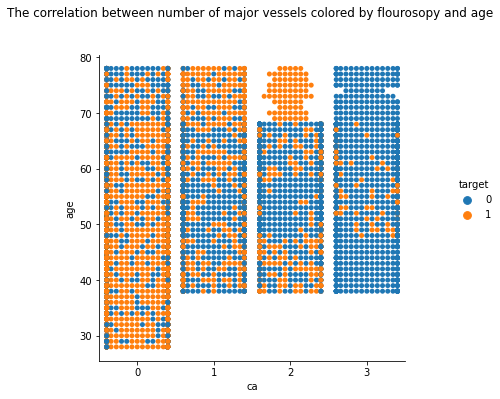

In [68]:
g = sns.catplot(x='ca', y='age', hue='target', data=data, kind="swarm")
g.fig.suptitle(
    'The correlation between number of major vessels colored by flourosopy and age', y=1.1)
plt.show()


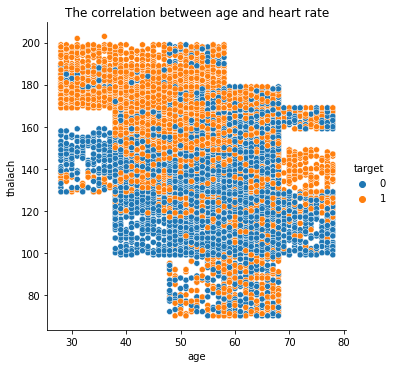

In [69]:
sns.relplot(x='age', y='thalach', data=data, hue='target', legend="full")
plt.title('The correlation between age and heart rate')
plt.show()


In [70]:
X = data.drop("target", axis=1)
y = data["target"]

len(X), len(y)

(21060, 21060)

In [71]:
train_scores = []
test_scores = []


neighbors = range(1,21)
# Knn
knn_clf = KNeighborsClassifier()


for i in neighbors:
    
    knn_clf.set_params(n_neighbors=i)
    
    knn_clf.fit(x_train, y_train)
    
    train_scores.append(knn_clf.score(x_train, y_train))
    
    test_scores.append(knn_clf.score(x_test, y_test))

c:\Users\FPT Shop\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\FPT Shop\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

KNN : 88.70%


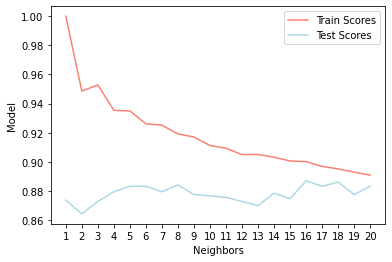

In [72]:
plt.plot(neighbors,train_scores, color="salmon", label="Train Scores");
plt.plot(neighbors,test_scores, color="lightblue", label="Test Scores");

plt.xlabel("Neighbors")
plt.ylabel("Model")
plt.xticks(np.arange(1,21,1))
plt.legend();

print(f"KNN : {max(test_scores)*100:.2f}%")

In [80]:
numOfRightAnswer = 0
for item in testSet.values:
    knn = kNearestNeighbor(trainSet, item, 5)
    answer = findMostOccur(knn)
    numOfRightAnswer += item[-1] == answer
    print("Thực tế: {} -> Dự đoán: {}".format(item[-1], answer))
print(f"Độ chính xác : {(numOfRightAnswer / len(testSet))*100:.2f}%")
# print(numOfRightAnswer / len(testSet))

Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 0.0 -> Dự đoán: 1.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 1.0 -> Dự đoán: 0.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 0.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 1.0 -> Dự đoán: 0.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 0.0 -> Dự đoán: 1.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 1.0 -> Dự đoán: 0.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 1.0 -> Dự đoán: 1.0
Thực tế: 1.0 -> Dự đoán: 0.0
Thực tế: 0.0 -> Dự đoán: 0.0
Thực tế: 1.0 -